# Fig. 1A. OOI echosounder locations

Code for plotting coastlines and bathymetry map are from this [notebook](https://github.com/oceanhackweek/ohw19-tutorial-data-access-viz/blob/master/04.1-AUVs-Argo_ERDDAP.ipynb) authored by [Filipe Fernandes](https://github.com/ocefpaf/) in preparation for a tutorial in [Oceanhackweek 2019](https://oceanhackweek.github.io/).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from palettable import colorbrewer

In [2]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

LAND = colorbrewer.get_map("Greens", "sequential", 9)
OCEAN = colorbrewer.get_map("Blues", "sequential", 9, reverse=True)
LAND_OCEAN = np.array(OCEAN.mpl_colors + LAND.mpl_colors)

In [3]:
# Cabled echosounder locations
shbp = [44.6371, -124.306]
eao = [44.3741, -124.956]

In [4]:
# City locations
newport = [44.6368, -124.0535]
astoria = [46.1879, -123.8313]

In [5]:
# Uncabled echosounder locations
wa_offshore = [46.8508, -124.972]
wa_shelf = [46.9859, -124.566]
wa_inshore = [47.1336, -124.272]
or_inshore = [44.6598, -124.095]
uncabled = np.array([or_inshore, wa_inshore, wa_shelf, wa_offshore])

In [6]:
def add_etopo2(extent, ax, levels=None):
    import iris

    url = ("http://gamone.whoi.edu/thredds/dodsC/usgs/data0/bathy/ETOPO2v2c_f4.nc")
    cube = iris.load_cube(url)
    lon = iris.Constraint(x=lambda cell: extent[0] <= cell <= extent[1])
    lat = iris.Constraint(y=lambda cell: extent[2] <= cell <= extent[3])
    cube = cube.extract(lon & lat)
    lons = cube.coord("x").points
    lats = cube.coord("y").points
    
    levels = sorted(
        set(
            np.r_[
                [-4500, -3500, -2500, -1500, -1000, -500],  # bathy
                [-200, -10, 0],  # coast  # WJ added 0
#                 [500,1000,1500,2500],  # topo
            ].astype(int)
        )
    )

    cs = ax.contourf(lons, lats, cube.data, levels=levels,
        colors=LAND_OCEAN, zorder=0, alpha=0.9)

    # ax.contour(lons, lats, cube.data, levels=levels[::6], 
    #            colors='k', linestyles='solid', alpha=0.3)

    cbar = fig.colorbar(cs)
    cbar.set_ticks(levels)
    cbar.ax.tick_params(labelsize=16)
    ax_pos = ax.get_position()
    cax_pos = cbar.ax.get_position()
    cbar.ax.set_position([cax_pos.x0+0.1, ax_pos.y0, cax_pos.width*8, ax_pos.height*0.6])
    cbar.ax.set_ylabel('Depth (m)', fontsize=20, labelpad=12)

In [7]:
def make_map(extent, figsize=(12, 12), projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(
        figsize=figsize, subplot_kw={"projection": projection}
    )
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.ylines = gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-128, -126, -124, -122])
    gl.ylocator = mticker.FixedLocator([42, 44, 46, 48, 50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    ax.coastlines(resolution="50m")
    return fig, ax

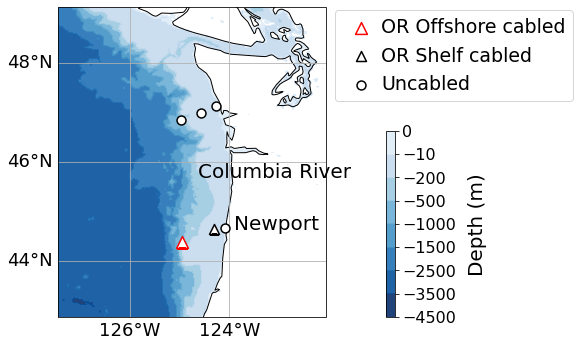

In [8]:
# Use cartopy
extent = (eao[1]-2.5, eao[1]+2.9, eao[0]-1.5, eao[0]+4.75)
fig, ax = make_map(extent, figsize=(6, 6))
add_etopo2(extent, ax)

h_eao = ax.scatter(
    eao[1], eao[0], s=140, marker='^', lw=1.5, edgecolor='r', facecolor='w', zorder=10)
h_shbp = ax.scatter(
    shbp[1], shbp[0], s=100, marker='^', lw=1.5, edgecolor='k', facecolor='w', zorder=10)
h_uncabled = ax.scatter(
    uncabled[:,1], uncabled[:,0], s=80, marker='o', lw=1.5, edgecolor='k', facecolor='w', zorder=10)

tt_newport = ax.text(
    x=newport[1]+0.15, y=newport[0]-0, s='Newport', fontsize=20)
tt_astoria = ax.text(
    x=astoria[1]-0.8, y=astoria[0]-0.5, s='Columbia River', fontsize=20)

plt.legend(
    [h_eao,h_shbp,h_uncabled], ['OR Offshore cabled', 'OR Shelf cabled', 'Uncabled'], 
    bbox_to_anchor=(1.96,1.02), handletextpad=0.05, fontsize=19)

plt.show()

fig.savefig(os.path.join('../figs/fig_data_source.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0.1)